# RFM Segmentation Online Sales

RFM (Recency, Frequency, Monetary) analysis is used to analyse customer behaviour for the purpose of market segmentation (Chen et. al and references therein). By observing a set of transactions each customer has made over a period of time, RFM analysis aims at grouping customers with similar buying patterns based on the following characteristics of each customer during the observation 
period:
  * Recency - How recently did this customer make his/her last 
purchase?
  * Frequency - How often did this customer make purchases?
  * Monetary value - How much did this customer spend?

Previously this data set was explored in the following notebook [sales_dasbhoard_eda notebook](https://github.com/Aljgutier/sales_analytics/blob/main/eda_bi_transforms_onlinesales.ipynb).

Methods
  * Kmeans Clustering 
  * Elbow Method
  * Silhouette Plots
  * Geo Plots ... cartopy

# Imports and Notebook Setup

In [1009]:

import matplotlib.pyplot as plt
import matplotlib.style
import pandas as pd
import numpy as np
import beautifulplots as bp
import seaborn as sns
import datetime as dt

In [975]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', None)

# Load and Clean Data

online sales csv

In [982]:
datapath = './data_onlinesales'
filename = 'online_sales_uci.csv'
df_sales = pd.read_csv(f'{datapath}/{filename}', parse_dates=['InvoiceDate'] )

df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase
0,545279,21238,RED RETROSPOT CUP,6,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer
1,545279,22844,VINTAGE CREAM DOG FOOD CONTAINER,1,2011-03-01,8.50,17811.0,United Kingdom,Repeat Customer
2,545279,21731,RED TOADSTOOL LED NIGHT LIGHT,4,2011-03-01,1.65,17811.0,United Kingdom,Repeat Customer
3,545279,21240,BLUE POLKADOT CUP,12,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer
4,545279,22845,VINTAGE CREAM CAT FOOD CONTAINER,12,2011-03-01,5.55,17811.0,United Kingdom,Repeat Customer


In [4]:
df_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Sales Revenue

In [5]:
df_sales['SalesRevenue']=df_sales['Quantity']*df_sales['UnitPrice']
df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue
0,545279,21238,RED RETROSPOT CUP,6,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer,5.1
1,545279,22844,VINTAGE CREAM DOG FOOD CONTAINER,1,2011-03-01,8.50,17811.0,United Kingdom,Repeat Customer,8.5
2,545279,21731,RED TOADSTOOL LED NIGHT LIGHT,4,2011-03-01,1.65,17811.0,United Kingdom,Repeat Customer,6.6
3,545279,21240,BLUE POLKADOT CUP,12,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer,10.2
4,545279,22845,VINTAGE CREAM CAT FOOD CONTAINER,12,2011-03-01,5.55,17811.0,United Kingdom,Repeat Customer,66.6


Nulls Exist for Description and Quantity

Lets explore from the perspective of what is usef for RFM. 
* eliminate null customerID ... not useful without the customerID
* most of null Descriptioms appear to be filled for other stock codes. They can probably be filled in from non missing values
* ... we do not need descriptions for this exercise, so we will not fix
* Cleanng customer ID fixes Description

In [6]:
df_sales.isnull().any()/len(df_sales)

InvoiceNo         0.000000
StockCode         0.000000
Description       0.000002
Quantity          0.000000
InvoiceDate       0.000000
UnitPrice         0.000000
CustomerID        0.000002
Country           0.000000
RepeatPurchase    0.000000
SalesRevenue      0.000000
dtype: float64

In [13]:
df_sales[df_sales['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue
669,559792,21067,NaN,-66,2011-07-12,0.00,NaN,United Kingdom,Repeat Customer,-0.00
670,559796,20723,STRAWBERRY CHARLOTTE BAG,28,2011-07-12,2.46,NaN,United Kingdom,Repeat Customer,68.88
671,559796,22725,ALARM CLOCK BAKELIKE CHOCOLATE,2,2011-07-12,8.29,NaN,United Kingdom,Repeat Customer,16.58
672,559796,22727,ALARM CLOCK BAKELIKE RED,2,2011-07-12,8.29,NaN,United Kingdom,Repeat Customer,16.58
673,559796,22356,CHARLOTTE BAG PINK POLKADOT,16,2011-07-12,2.46,NaN,United Kingdom,Repeat Customer,39.36
...,...,...,...,...,...,...,...,...,...,...
541904,551340,22223,CAKE PLATE LOVEBIRD PINK,1,2011-04-27,9.96,NaN,United Kingdom,Repeat Customer,9.96
541905,551340,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-04-27,5.79,NaN,United Kingdom,Repeat Customer,5.79
541906,551340,22420,LIPSTICK PEN BABY PINK,1,2011-04-27,0.83,NaN,United Kingdom,Repeat Customer,0.83
541907,551340,21272,SALLE DE BAIN HOOK,1,2011-04-27,2.46,NaN,United Kingdom,Repeat Customer,2.46


In [7]:
df_sales[df_sales['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue
669,559792,21067,NaN,-66,2011-07-12,0.0,NaN,United Kingdom,Repeat Customer,-0.0
1572,559825,21067,NaN,23,2011-07-12,0.0,NaN,United Kingdom,Repeat Customer,0.0
1575,578693,21811,NaN,1,2011-11-25,0.0,NaN,United Kingdom,Repeat Customer,0.0
1578,578738,21638,NaN,-33,2011-11-25,0.0,NaN,United Kingdom,Repeat Customer,-0.0
3587,536414,22139,NaN,56,2010-12-01,0.0,NaN,United Kingdom,New Customer,0.0
...,...,...,...,...,...,...,...,...,...,...
541679,551320,21897,NaN,60,2011-04-27,0.0,NaN,United Kingdom,Repeat Customer,0.0
541680,551321,22719,NaN,36,2011-04-27,0.0,NaN,United Kingdom,Repeat Customer,0.0
541681,551322,85099F,NaN,101,2011-04-27,0.0,NaN,United Kingdom,Repeat Customer,0.0
541686,551326,85017A,NaN,-2,2011-04-27,0.0,NaN,United Kingdom,Repeat Customer,-0.0


In [17]:
df_sales[df_sales['StockCode']=='21811']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue
1575,578693,21811,NaN,1,2011-11-25,0.00,NaN,United Kingdom,Repeat Customer,0.00
3469,536409,21811,CHRISTMAS HANGING HEART WITH BELL,1,2010-12-01,1.25,17908.0,United Kingdom,New Customer,1.25
4484,536544,21811,CHRISTMAS HANGING HEART WITH BELL,1,2010-12-01,2.51,NaN,United Kingdom,New Customer,2.51
5170,536569,21811,CHRISTMAS HANGING HEART WITH BELL,2,2010-12-01,1.25,16274.0,United Kingdom,New Customer,2.50
5241,536572,21811,CHRISTMAS HANGING HEART WITH BELL,12,2010-12-01,1.25,16539.0,United Kingdom,New Customer,15.00
...,...,...,...,...,...,...,...,...,...,...
532803,577038,21811,HANGING HEART WITH BELL,12,2011-11-17,0.39,14796.0,United Kingdom,Repeat Customer,4.68
533541,576776,21811,check,-240,2011-11-16,0.00,NaN,United Kingdom,Repeat Customer,-0.00
535152,571292,21811,HANGING HEART WITH BELL,2,2011-10-16,0.39,15311.0,United Kingdom,Repeat Customer,0.78
536725,562553,21811,HANGING HEART WITH BELL,1,2011-08-05,2.46,NaN,United Kingdom,Repeat Customer,2.46


In [8]:
df_sales[df_sales['StockCode']=='21067']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue
669,559792,21067,NaN,-66,2011-07-12,0.00,NaN,United Kingdom,Repeat Customer,-0.00
1572,559825,21067,NaN,23,2011-07-12,0.00,NaN,United Kingdom,Repeat Customer,0.00
5837,536592,21067,VINTAGE RED TEATIME MUG,1,2010-12-01,2.51,NaN,United Kingdom,New Customer,2.51
27506,541205,21067,VINTAGE RED TEATIME MUG,6,2011-01-14,1.25,18106.0,United Kingdom,New Customer,7.50
27511,541205,21067,VINTAGE RED TEATIME MUG,1,2011-01-14,1.25,18106.0,United Kingdom,New Customer,1.25
...,...,...,...,...,...,...,...,...,...,...
507041,548516,21067,VINTAGE RED TEATIME MUG,1,2011-03-31,2.46,NaN,United Kingdom,Repeat Customer,2.46
527630,560402,21067,NaN,2,2011-07-18,0.00,NaN,United Kingdom,Repeat Customer,0.00
528644,551171,21067,VINTAGE RED TEATIME MUG,1,2011-04-26,1.25,13263.0,United Kingdom,Repeat Customer,1.25
539061,538071,21067,VINTAGE RED TEATIME MUG,3,2010-12-09,2.51,NaN,United Kingdom,Repeat Customer,7.53


df_sales_clean

In [9]:
df_sales_clean=df_sales[df_sales['CustomerID'].notna()]

df_sales_clean.isnull().any()/len(df_sales_clean)

InvoiceNo         0.0
StockCode         0.0
Description       0.0
Quantity          0.0
InvoiceDate       0.0
UnitPrice         0.0
CustomerID        0.0
Country           0.0
RepeatPurchase    0.0
SalesRevenue      0.0
dtype: float64

# RFM DataFrame

_Recency_ - how many days from since the last (most recent) purchase

_Frequency_ - count unique orders (unique invoices) regardless of the number of items in each purchase (invoice)

_Monetary Value_ - sum of the total customer spend


In [1176]:
# similar to the following example
# https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945

# Create max_date_plus_1 variable
df = df_sales_clean.copy()
import datetime
df['InvoiceDate'] = df['InvoiceDate'].dt.date # change InvoiceDate to date from timestamp
max_date_plus_1 = df['InvoiceDate'].max() + datetime.timedelta(days=1)
max_date_plus_1 

# Create RFM data frame ... aggregate by each customer 
aggs={
    'InvoiceDate': lambda x: (max_date_plus_1 - x.max()).days,
    'InvoiceNo': 'nunique', # use nunique ... count will count duplicate when customer buys multiple items in one invoice
    'SalesRevenue': 'sum'
    }
df_rfm= df.groupby(['CustomerID']).agg(aggs)
df_rfm = df_rfm.rename({'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency',
                        'SalesRevenue': 'MonetaryValue'}, axis=1) # change variable names

# Display
display(df_rfm.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


# Transform and Standardize

Look at distributions

All cases show very long tails.

Recency is well behaved while Frequency and MonetaryValue show some very large outliers

MonetaryValue has a few negative values. While negative transactions are okay for individual transactions they don't make sense for the summary. Perhaps, it is a customer that received a refund for a transaction prior to this dataset. In any case, they will not hurt the analysis so we will leave them in.

Notice below that the outer most frequncy outliers are eliminated with the net negative value outliers

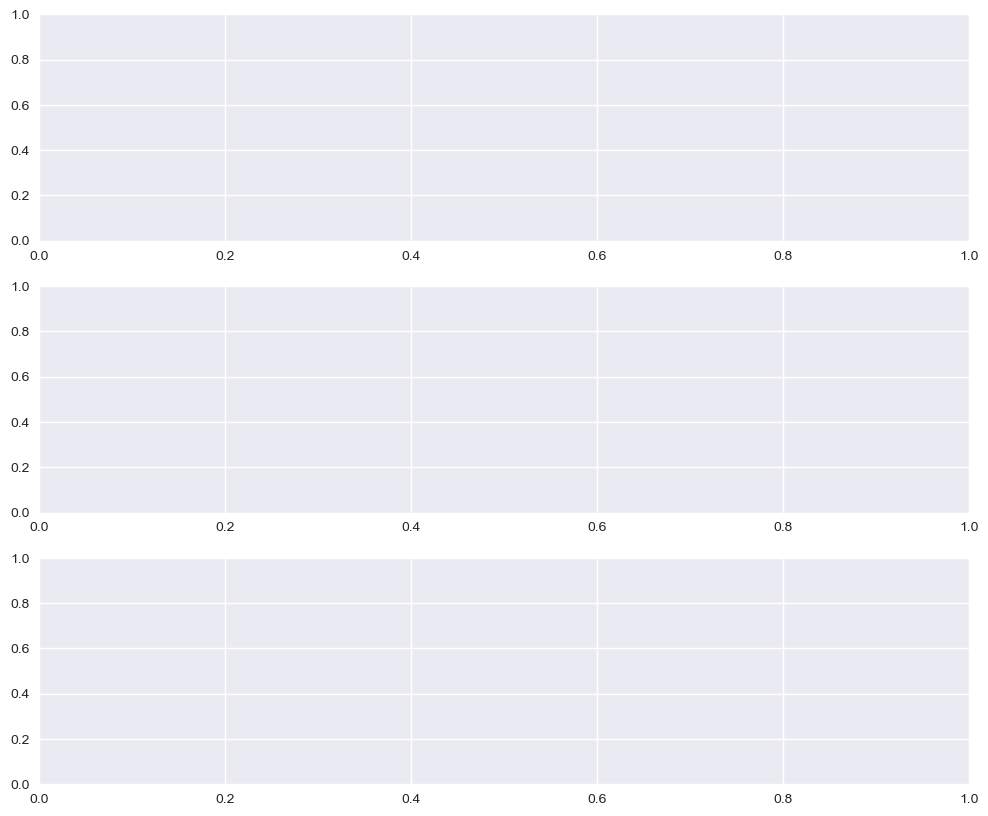

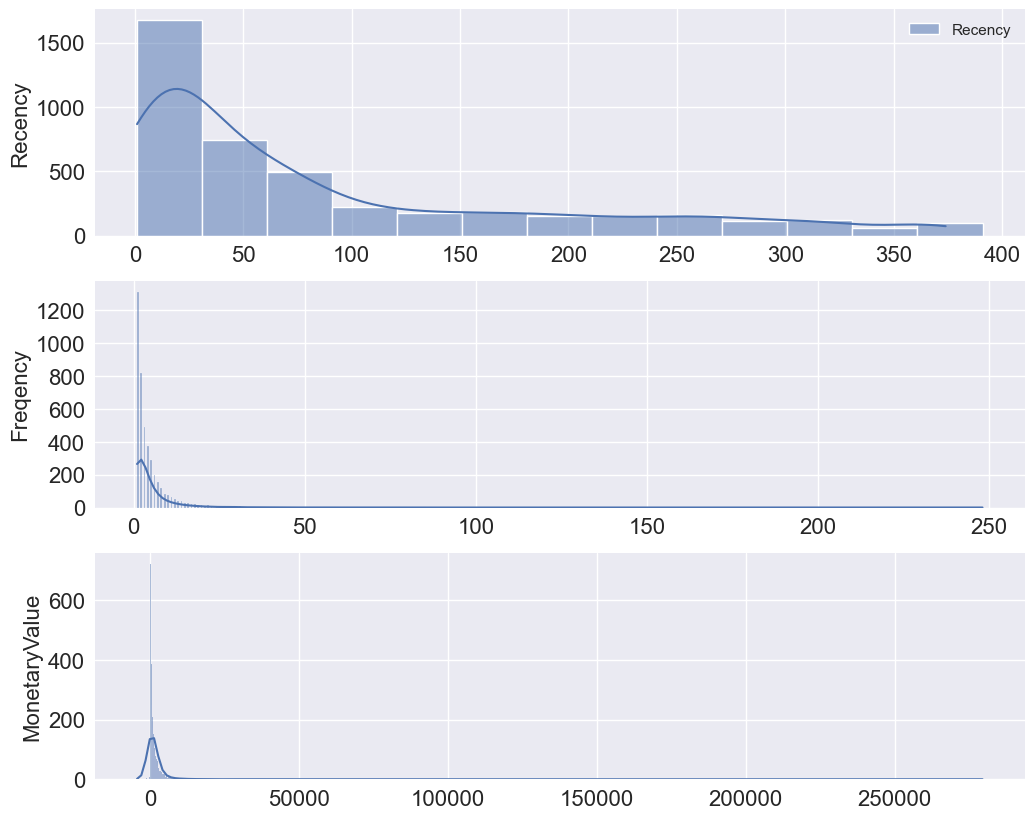

In [1177]:

plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12,10))
plot_defaults_dict = bp.plot_defaults() # get matplotlib defaults dictionary from beautifulplots
sns.set(style="ticks")

# Plot histogram
r = df_rfm[['Recency']]
g=sns.histplot(data = r, kde = True, binwidth=30, ax=ax[0])
plot_defaults_dict["y_axis_label"]='Recency'
bp.set_axisparams(plot_defaults_dict,ax[0],g) # set the axis parameters

f = df_rfm['Frequency']
g=sns.histplot(data = f, kde = True, ax=ax[1])
plot_defaults_dict["y_axis_label"]='Freqency'
bp.set_axisparams(plot_defaults_dict,ax[1],g) # set the axis parameters

m = df_rfm['MonetaryValue']
g=sns.histplot(data = m, kde = True, ax=ax[2])
plot_defaults_dict["y_axis_label"]='MonetaryValue'
bp.set_axisparams(plot_defaults_dict,ax[2],g) # set the axis parameters

plt.show()

Print basic stats for each parameter

In [1178]:
# print basic stats for each variable
print('describe count, max, min, and quartile statistics')
display(df_rfm.describe().T)

describe count, max, min, and quartile statistics


,count,mean,std,min,25%,50%,75%,max
Recency,4372.0,92.581199,100.772139,1.00,17.0000,51.000,144.000,374.00
Frequency,4372.0,5.075480,9.338754,1.00,1.0000,3.000,5.000,248.00
MonetaryValue,4372.0,1898.459701,8219.345141,-4287.63,293.3625,648.075,1611.725,279489.02


look at boxplots to get a better understanding of outliers

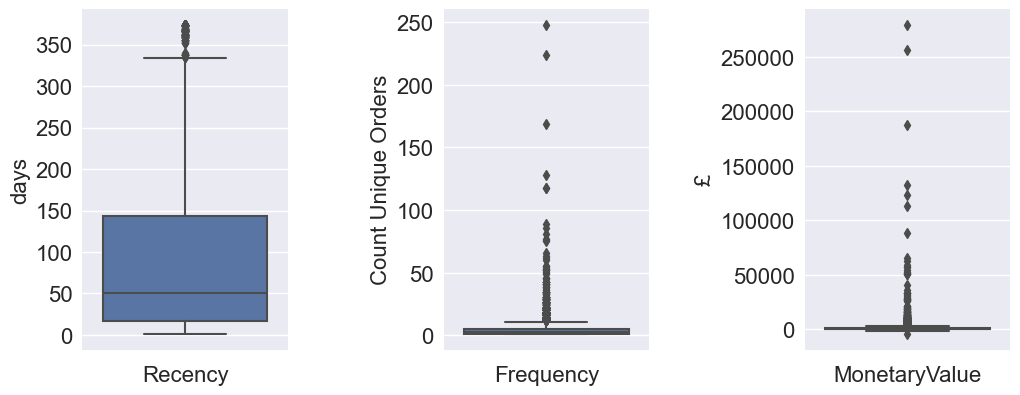

In [1179]:
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12,6))
plot_defaults_dict = bp.plot_defaults() # get matplotlib defaults dictionary from beautifulplots
fig.tight_layout(pad=7.0)
seaborn.set(style='whitegrid')
 
g=sns.boxplot(data=df_rfm[['Recency']] ,  y='Recency', ax=ax[0] )  
plot_defaults_dict['y_axis_label']='days'
plot_defaults_dict['x_axis_label']='Recency'
bp.set_axisparams(plot_defaults_dict,ax[0],g)


g=sns.boxplot(data=df_rfm[['Frequency']] ,  y='Frequency', ax=ax[1] )  
plot_defaults_dict['y_axis_label']='Count Unique Orders'
plot_defaults_dict['x_axis_label']='Frequency'
bp.set_axisparams(plot_defaults_dict,ax[1],g)


g=sns.boxplot(data=df_rfm[['MonetaryValue']] ,  y='MonetaryValue', ax=ax[2] )  
plot_defaults_dict['y_axis_label']='£'
plot_defaults_dict['x_axis_label']='MonetaryValue'
bp.set_axisparams(plot_defaults_dict,ax[2],g)

plt.show()

Eliminating the negative monetary value customers allows us to do a box-cox transformation on the MonetaryValue column (in addition to the others)

In [1180]:
# remove customers with net negative sales
df_rfm_s=df_rfm[df_rfm['MonetaryValue']>0 ].copy()

print('Customers with negative Monetary Value')
display(df_rfm_s[df_rfm_s['MonetaryValue']<= 0])

Customers with negative Monetary Value


,Recency,Frequency,MonetaryValue
CustomerID,,,


deskew ... boxcox transformation ... we could also try root, 1/x, and log. However after a few tries will find that boxcox does consistently well at deskewing.

In [1181]:
# Box Cox Transform 
# https://www.geeksforgeeks.org/box-cox-transformation-using-python/

from scipy import stats

df_rfm_s["r"] , r_lambda = stats.boxcox(df_rfm_s['Recency'])
df_rfm_s["f"] , f_lambda = stats.boxcox(df_rfm_s['Frequency'])
df_rfm_s["m"] , m_lambda = stats.boxcox(df_rfm_s['MonetaryValue'])

# fisher person skewness
skewness = df_rfm_s.skew()
print("skewness = ")
display(pd.DataFrame(skewness).T) #skewness is a series ... transform to dataframe


skewness = 


,Recency,Frequency,MonetaryValue,r,f,m
0,1.267376,11.362179,21.596106,-0.063971,0.108953,0.348221


Standardize ... zero mean and unit variance

In [1182]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_rfm_s[['r','f','m']])
df_rfm_s[['r','f','m']]=scaler.transform(df_rfm_s[['r','f','m']])

display(df_rfm_s.describe().T)

display(df_rfm_s)

,count,mean,std,min,25%,50%,75%,max
Recency,4320.0,9.088125e+01,99.130828,1.000000e+00,17.000000,50.000000,139.000000,374.000000
Frequency,4320.0,5.117130e+00,9.386392,1.000000e+00,1.000000,3.000000,6.000000,248.000000
MonetaryValue,4320.0,1.924374e+03,8264.936833,7.105427e-15,302.435000,657.850000,1626.260000,279489.020000
r,4320.0,-9.210739e-17,1.000116,-2.186089e+00,-0.730451,0.010594,0.834302,1.763243
f,4320.0,-6.743577e-17,1.000116,-1.266615e+00,-1.266615,0.175883,0.854199,2.739443
m,4320.0,3.289550e-17,1.000116,-8.432580e+00,-0.673659,-0.107783,0.601654,5.902218


,Recency,Frequency,MonetaryValue,r,f,m
CustomerID,,,,,,
12347.0,3,7,4310.00,-1.694518,0.985408,1.431175
12348.0,76,4,1797.24,0.332534,0.476033,0.683518
12349.0,19,1,1757.55,-0.659539,-1.266615,0.665169
12350.0,311,1,334.40,1.579371,-1.266615,-0.602646
12352.0,37,11,1545.41,-0.208592,1.334363,0.560171
...,...,...,...,...,...,...
18280.0,278,1,180.60,1.470050,-1.266615,-1.028410
18281.0,181,1,80.82,1.068607,-1.266615,-1.550672
18282.0,8,3,176.60,-1.180717,0.175883,-1.043461


Plot the transformed data

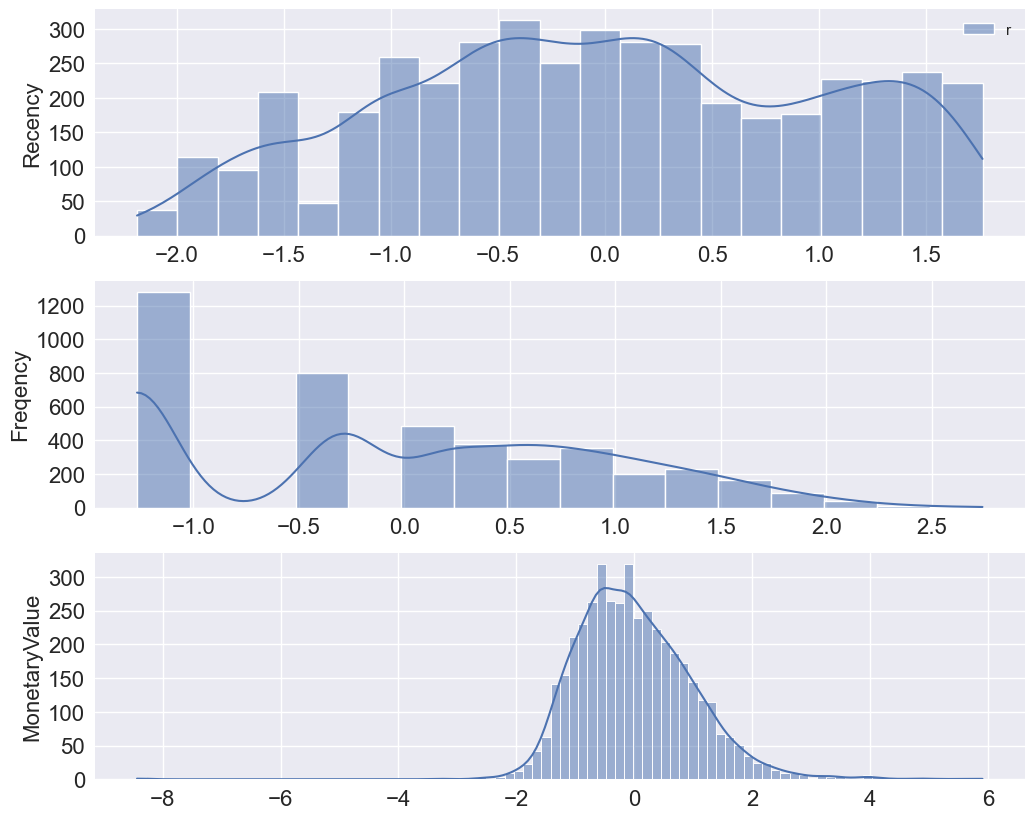

In [1183]:

plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12,10))
plot_defaults_dict = bp.plot_defaults() # get matplotlib defaults dictionary from beautifulplots
sns.set(style="ticks")

# Plot histogram
r = df_rfm_s[['r']]
g=sns.histplot(data = r, kde = True, ax=ax[0])
plot_defaults_dict["y_axis_label"]='Recency'
bp.set_axisparams(plot_defaults_dict,ax[0],g) # set the axis parameters

f = df_rfm_s['f']
g=sns.histplot(data = f, kde = True, ax=ax[1])
plot_defaults_dict["y_axis_label"]='Freqency'
bp.set_axisparams(plot_defaults_dict,ax[1],g) # set the axis parameters

m = df_rfm_s['m']
g=sns.histplot(data = m, kde = True, ax=ax[2])
plot_defaults_dict["y_axis_label"]='MonetaryValue'
bp.set_axisparams(plot_defaults_dict,ax[2],g) # set the axis parameters

plt.show()

look at boxplots on standardized variables

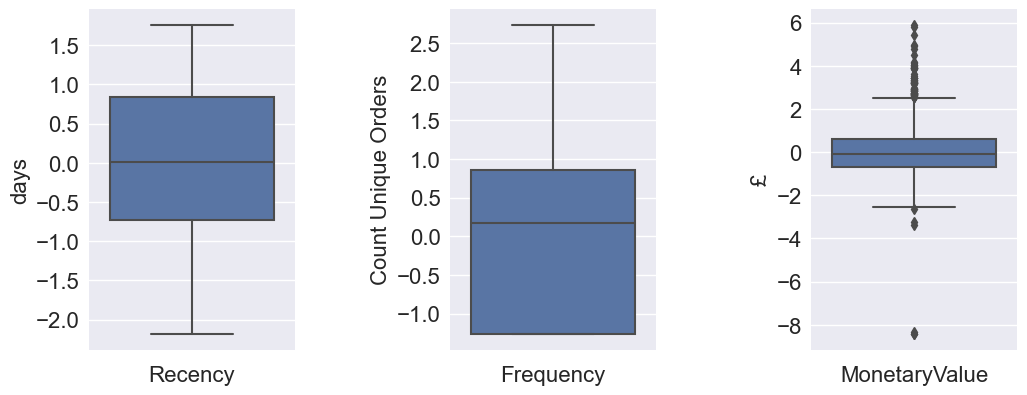

In [1184]:
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12,6))
plot_defaults_dict = bp.plot_defaults() # get matplotlib defaults dictionary from beautifulplots
fig.tight_layout(pad=7.0)
seaborn.set(style='whitegrid')
 
g=sns.boxplot(data=df_rfm_s[['r']] ,  y='r', ax=ax[0] )  
plot_defaults_dict['y_axis_label']='days'
plot_defaults_dict['x_axis_label']='Recency'
bp.set_axisparams(plot_defaults_dict,ax[0],g)


g=sns.boxplot(data=df_rfm_s[['f']] ,  y='f', ax=ax[1] )  
plot_defaults_dict['y_axis_label']='Count Unique Orders'
plot_defaults_dict['x_axis_label']='Frequency'
bp.set_axisparams(plot_defaults_dict,ax[1],g)


g=sns.boxplot(data=df_rfm_s[['m']] ,  y='m', ax=ax[2] )  
plot_defaults_dict['y_axis_label']='£'
plot_defaults_dict['x_axis_label']='MonetaryValue'
bp.set_axisparams(plot_defaults_dict,ax[2],g)

plt.show()

# Cluster Analysis

## Overview of Cluster Analysis Methods

**Overview of Cluster Analsyis Methods**
* K-Means - clustering algorithm. The kmeans algorithm is employed in this exercise. 
* Elbow Method - evaluates inter-cluster distance (SSD) against k (number of clusters). Observe the knee ("elbow") of the curve to assess the point of diminishing returns for further subdividing the clusters.
* Silhouette Scores - evaluates the intra-cluster distance and inter-cluster distance. The Silhouette method ranges from +1 to -1. The score decreases as overlap between clusters increases. Silhouette plots provide a visual of cluster widths, cluster overlap, and silhouette score.
* Heatmap - A cluster heatmap provides a visual of the clusters based on the cluster centers as prototypes for each cluster.
* Scatter Plots - 3D Scatter plots provide a 3D visualization of the cluster membership including all the input data from which the clustering algorithm derived the clusters. 
* Cluster Summaries - The input Data is joined with the cluster labels and cluster names/Segment names (human interpretation for each cluster). Based on this DataFrame (cluster labels and cluster names) additional summary statistics are derived, such as minimums, maximums, averages, medians, etc., for each segment/cluster.


All these methods are employed to derive the segmentation (i.e., clusters with cluster names), which best fits the problem at hand. Often, the first two methods above suggested as sufficient to determine the number of clusters and cluster interpretation, however this example (detailed below) illustrates how all of the analysis methods lead to a robust RFM segmentation. The information from any one method falls short of providing the insight needed to obtain sufficient insight about the resulting segments.

## Elbow Method

* Elbow Method (several methods can be used - ASU MKT 550)
  * Within Cluster Variance / Between Cluster Variance ... WCSS (i.e., Inertia ) / Distortion
  * Sum of distance squared (WCSS) ... within cluster sum of squares
  * % Variance Explained - sum sqr dist within / (sum sqr dis within + sum sqr dist between)
  * Example - For the given number of centroids, k, the algorithm will converge with a WCSS_k. As k increases from 1 to K, WCSS_k will diminish asymptotically, i.e., diminishing returns. By convention, it is typial to choose N clusters corresponding to the knee of the curve when plotting WCSS_k for k:1 to K

  * WCSS - sum of squared distance to the cluster centroid.

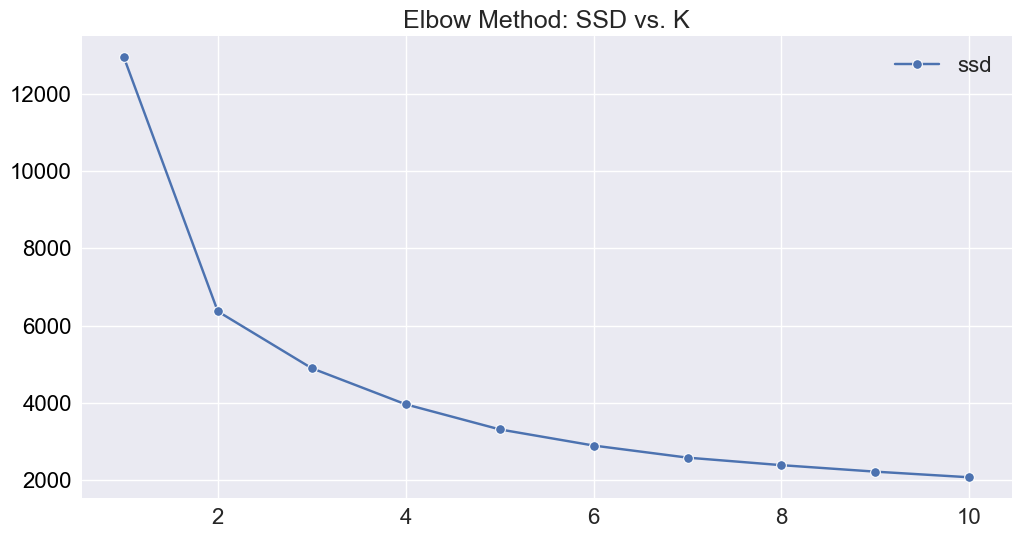

In [194]:
from sklearn.cluster import KMeans

cluster_cols=['r','f','m']

k_list = []
ssd_list = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_rfm_s[cluster_cols])
    k_list.append(k)
    ssd_list.append(kmeans.inertia_ )
    
df_ssd_k=pd.DataFrame({"k":k_list,"ssd":ssd_list})    
bp.lineplot(df_ssd_k, x="k",y="ssd", marker="o", y_axis_format='0.0f',figsize=(12,6), title='Elbow Method: SSD vs. K')


THe knee of the curve appears to be at 2 or 3 clusters

After that, there is linear diminishing returns for additional splitting

It's too early to determine the optimum k. 

Let's look at the silhoute graphs/score and also heatmap to better decide on k

Often k is not only a scientific choice, but the choice also depends on the goals of the business requirement


## Silhouette Scores and Plots

* Silhouette Score (i.e., coeficient) 
  * from -1 to 1. 
  * The Silhouette Coefficient (i.e., score) is calculated using the mean intra-cluster distance (distance to all other clusters) (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

  * Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.( https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

  * Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster (overlaps with another cluster).

In [237]:

# Silhouette Plots Function
# Reference
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score

class gridplot:
    # Initializer / Instance Attributes
    def __init__(self, plotgrid=(1,1),wspace=0.1,hspace=0.1,figsize=(18,24)):
        # plotgrid Nrows x Ncol grid
        self.figsize=figsize 
        self.wspace=wspace
        self.hspace=hspace
        self.fig = plt.figure(figsize=self.figsize)
        self.fig.subplots_adjust(wspace=self.wspace, hspace=self.hspace)
        self.plotgrid=plotgrid

        
    # instance method
    def ax(self,nthplot=1):
        ax = self.fig.add_subplot(self.plotgrid[0],self.plotgrid[1],nthplot)
        return ax

def silhouetteplots(df,range_n_clusters,figsize=(18,18)):
    plt_style='seaborn'
    matplotlib.style.use(plt_style)
    N=len(range_n_clusters)+1
    grdp=gridplot(plotgrid=(int(N/2 + 0.5),2),figsize=figsize,hspace=0.2)
    
    cluster_sizes_dict = {}
    cluster_scores_dict ={}
    for n_clusters,k in zip(range_n_clusters,range(1,N)):
        print(n_clusters,'.. ',end='', sep='')

        ax1=grdp.ax(k)
    
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.25, 1]
        ax1.set_xlim([-0.25, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        
        cluster_scores_dict[n_clusters] = silhouette_avg
        
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        cluster_sizes_k =[]
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
                
            cluster_sizes_k.append(len(ith_cluster_silhouette_values))

            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #ax1.set_title("The silhouette plot for the various clusters.")
        
        ax1.set_ylabel("Cluster Label")
        
        cluster_sizes_dict[n_clusters]=cluster_sizes_k
        
        if k>=N-2:
            ax1.set_xlabel("Silhouette Coefficient")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.show()
    
    print('silhoute_scores =',cluster_scores_dict)
    print('\ncluster_sizes =',cluster_sizes_dict)

THere is good separation of clusters up to 6 clusters

At 7 and 8 clusters we seem one very thin cluster though the splitting still appears good without excessive cluster overlap

the average silhouette score (red line, printed below) seems to hold relatively constant 

3.. 4.. 5.. 6.. 7.. 8.. 

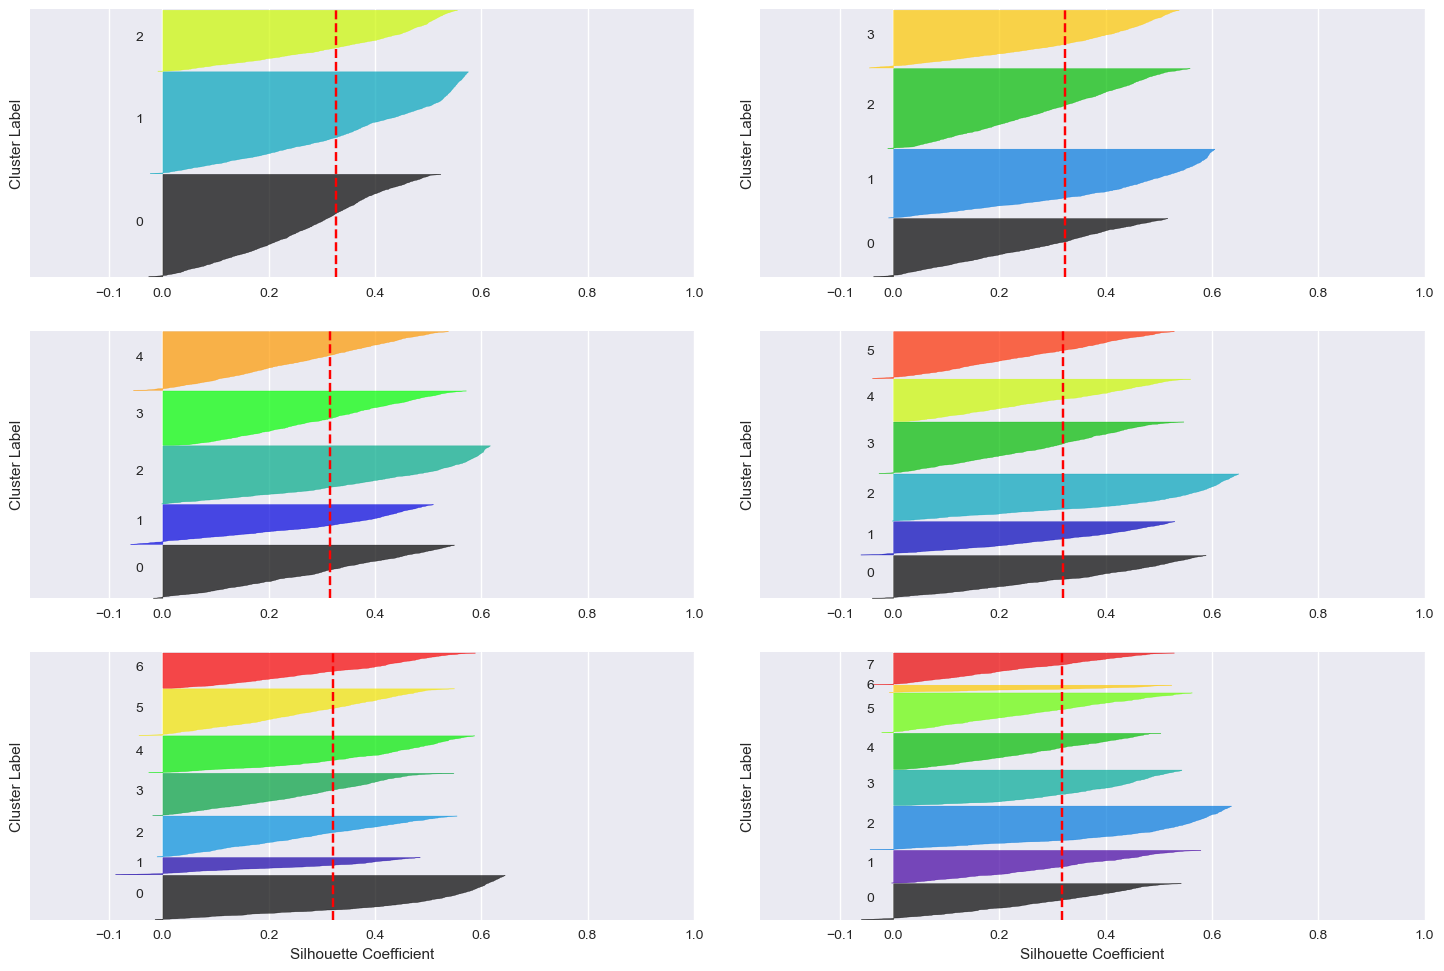

silhoute_scores = {3: 0.32756134988333857, 4: 0.32272344636744293, 5: 0.315023979190564, 6: 0.32008216567679515, 7: 0.321631231377466, 8: 0.3172653706080906}

cluster_sizes = {3: [1669, 1659, 992], 4: [951, 1123, 1304, 942], 5: [870, 652, 951, 887, 960], 6: [699, 546, 772, 842, 693, 768], 7: [727, 283, 672, 692, 605, 763, 578], 8: [593, 537, 720, 583, 595, 655, 118, 519]}


In [236]:
silhouetteplots(df_rfm_s[cluster_cols],range_n_clusters = [3, 4, 5, 6 , 7, 8],figsize=(18,16))

## Heatmap

In [1185]:

# Cluster Heatmap
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#corder=(0,7,5,6,9,8,1,2,3,4)
# custom labels
# https://stackoverflow.com/questions/33158075/custom-annotation-seaborn-heatmap
def clusterheatmap(df_centers_T,cmap='OrRd', fmt='.2g', annot=True, annot_text_size=12, figsize= (14,14)): 
    '''
    clusterheatmap visualizing the results of
    clustering operation, for example, output from kmeans.
    
    Args:
        df_centers_T (DataFrame): Cluster centers. These should be transposed so that the index of df_cluster_T are the column names used for clustering. 
        cmap (color map): default 'OrRd'
        annot (Object): Defaults to boolean, True. However it can contain an N-dimensional array of labels for annotatng the heatmap. THe default is to annotate wiht the cluster values. Sometimes other labels are preferred, for example with transformed variables or text labels (use fmt='' for text labels).
        fmt (string): fmt of annotation (labels). The default is '.2g' which assumes numeric labels, so it must be changed to fmt='' if the labels are text.
        annot_text_size (int): default = 12
        figsize (2-tuple): 2-tuple (w,h), designating the width (w) and height of the heatmap. Default = (14,14)
        
    Returns:
        Displays a heatmap. Returns None.

    Example:
        from sklearn.cluster import KMeans
        kmeans=kKMeans(n_clusters=k)
        kmeans.fit(df)
        df_centers_T = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns).T
        clusterheatmap(df_centers_T)
        
    '''
    #df_cols = df_centers.columns
    
    fig = plt.figure(figsize=figsize)
    plt_style='seaborn'
    matplotlib.style.use(plt_style)
    
    g=fig.ax = sns.heatmap(df_centers_T,cmap=cmap, 
                        yticklabels=df_centers_T.index,
                        annot=annot, fmt=fmt, annot_kws={'size': annot_text_size})

    g.set_xticklabels(g.get_xticklabels(), rotation=80, horizontalalignment='right', size=16)
    g.set_yticklabels(g.get_yticklabels(), size=16)

    plt.show()
    
    return None
    

In [1186]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Choose the number of clusters with the help of heatmap and make cluster interpretations


* 5 clusters is a good number of clusters for providing useful RFM segments
* 6 clusters were eveluated in which case the lost customers was split into med and lower value and a recency centroid of 129 vs 229. However, this does not lend very much useful insight. I find it more useful to stick to lesser number of clusters. In the future these 5 clusters could be further split based on additional sub clustering or business rules.

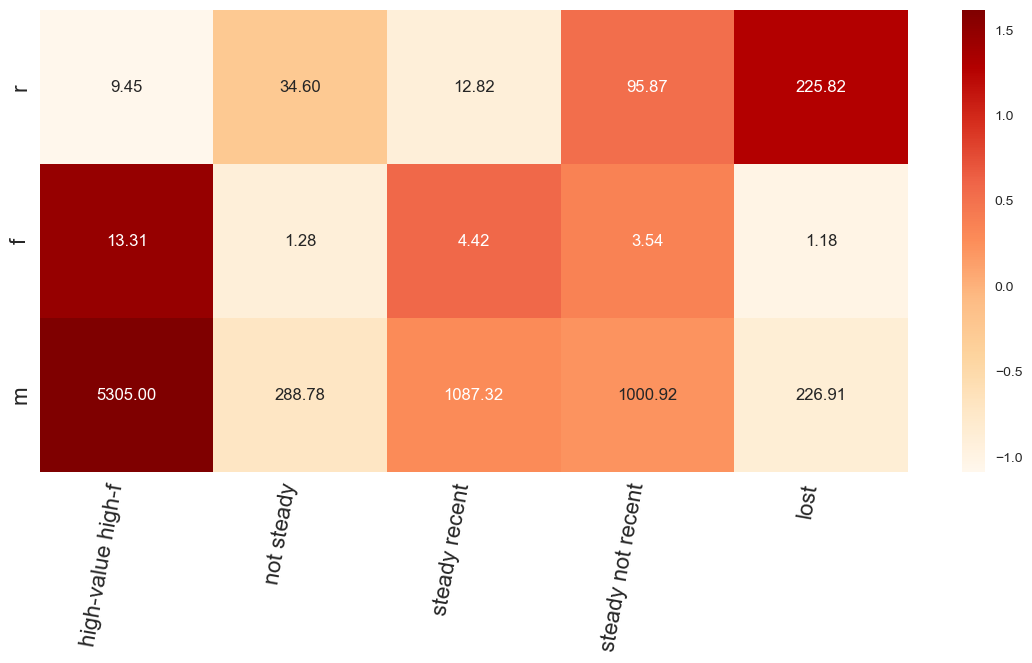

,high-value high-f,not steady,steady recent,steady not recent,lost
R,9.452898,34.596856,12.824737,95.868240,225.815697
F,13.309097,1.277046,4.419797,3.536115,1.179336
M,5304.997075,288.784492,1087.324078,1000.923109,226.912412


In [1198]:

k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_rfm_s[cluster_cols])

df_centers = pd.DataFrame(data=kmeans.cluster_centers_,columns=cluster_cols)
df_centers_T = df_centers.T # index are cluster cols, ... cols are cluster_num (cluster_label)

# get centers in the original non-transformed variable space
# inverse standard scaler
df_centers_ibc=pd.DataFrame(scaler.inverse_transform(df_centers[['r','f','m']]), columns=['R','F','M'] )
  
# inverse box cox ... 
# https://stackoverflow.com/questions/26391454/reverse-box-cox-transformation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html

from scipy.special import inv_boxcox
df_centers_ibc["R"] = inv_boxcox(df_centers_ibc['R'],r_lambda)
df_centers_ibc["F"] = inv_boxcox(df_centers_ibc['F'],f_lambda)
df_centers_ibc["M"] = inv_boxcox(df_centers_ibc['M'],m_lambda)
df_centers_ibc_T = df_centers_ibc.T

# reorder columns for better visualizaion/interpretation
# comment when trying new k
cl_list=[3,2,4,0,1]  # k =5
#cl_list=[2, 0, 4, 5,  3, 1] # k = 6
df_centers_T = df_centers_T[cl_list]
df_centers_ibc_T = df_centers_ibc_T[cl_list]

# iteratively name the clusters with human interpretation
# keep the origin numeric label in parenthesis for reference
# comment when trying new k
# k = 5
cluster_interpretations={  3:'high-value high-f' , 4:'steady recent', 0:'steady not recent', 2:'not steady', 1:'lost'  } 
# k = 6
#cluster_interpretations={  1:'lost low-v' , 4:'steady recent', 2:'high-value high-f', 0:'not steady', 3:'lost med-v' , 5:'steady not recent' } 

df_centers_T.rename(cluster_interpretations,axis=1,inplace=True)
df_centers_ibc_T.rename(cluster_interpretations,axis=1,inplace=True)

# put iterprentations bac into non transposed dataframe
df_centers_ibc = df_centers_ibc_T.T.reset_index().rename({"index":"csegment"},axis=1)
df_centers = df_centers_T.T.reset_index().rename({"index":"csegment"},axis=1)

# heatmap on transformed variables for better visualization
# annotate with the non-transformed values for better interpretation
annot= df_centers_ibc_T.values  #  # annotation form = [[],[]] ..] ... n-col (cluster cols) x k-values (k-clusters) ... each sub-array has k values               
clusterheatmap(df_centers_T, annot=annot, fmt='.2f',figsize=(14,6))

# print centers in non-transformed (inverse boxcox) for better understanding/interpretation
display(df_centers_ibc_T)

## Scatter Plots

Add cluster labels and segment names to df_rfm DataFrame

In [1199]:
# Add clusters back to df_rfm dataframe
df_rfm_cs = df_rfm_s.copy().reset_index()
df_rfm_cs['clabel'] = kmeans.labels_
df_rfm_cs['csegment'] = df_rfm_cs['clabel'].apply(lambda x: cluster_interpretations[x])
print('df_rfm_cs')
display(df_rfm_cs)


df_rfm_cs


,CustomerID,Recency,Frequency,MonetaryValue,r,f,m,clabel,csegment
0,12347.0,3,7,4310.00,-1.694518,0.985408,1.431175,3,high-value high-f
1,12348.0,76,4,1797.24,0.332534,0.476033,0.683518,0,steady not recent
2,12349.0,19,1,1757.55,-0.659539,-1.266615,0.665169,2,not steady
3,12350.0,311,1,334.40,1.579371,-1.266615,-0.602646,1,lost
4,12352.0,37,11,1545.41,-0.208592,1.334363,0.560171,4,steady recent
...,...,...,...,...,...,...,...,...,...
4315,18280.0,278,1,180.60,1.470050,-1.266615,-1.028410,1,lost
4316,18281.0,181,1,80.82,1.068607,-1.266615,-1.550672,1,lost
4317,18282.0,8,3,176.60,-1.180717,0.175883,-1.043461,4,steady recent
4318,18283.0,4,16,2094.88,-1.551663,1.587255,0.810406,3,high-value high-f


Scatter 3D

In [1200]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# https://stackoverflow.com/questions/52285104/3d-scatterplots-in-python-with-hue-colormap-and-legend 

def scatter3d(df, x, y, z, c, palette='tab10', color=None, cmap=None, ax = None, figsize=(14,14)):
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        _ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(_ax)
    else:
        _ax=ax
    
    x_data = df[x].values
    y_data = df[y].values
    z_data = df[z].values
    c_data = df[c].values
    
    # get colormap from seaborn

    if cmap == None:
        cmap = ListedColormap(sns.color_palette(palette, 12).as_hex())
        

    if color == None:
        sc=_ax.scatter(x_data,y_data,z_data, c=c_data ,cmap=cmap, s=40, alpha = 1 )
        # s := marker size, alpha := opaqueness
        
    else:
        # for a single color use color keyword and a color spec for each point
        #sc=_ax.scatter(x_data,y_data,z_data, s=40, c=len(df)*[color], alpha = 1 ) # this causes a confusiong warning !!!!
        sc=_ax.scatter(x_data,y_data,z_data, color=color )
        
    _ax.set_xlabel(x)
    _ax.set_ylabel(y)
    _ax.set_zlabel(z)
    
    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(.75, 1), loc=2)

    if ax is None:
        plt.show()
    
    return None


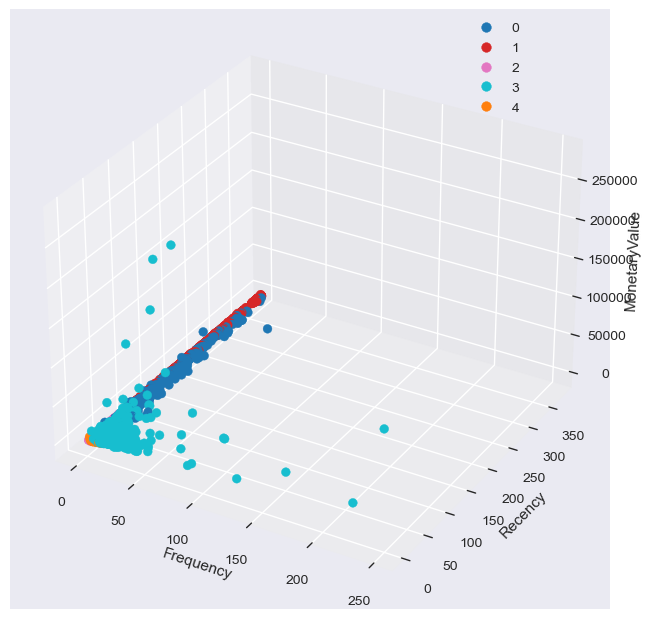

In [1201]:

scatter3d(df_rfm_cs,"Frequency","Recency","MonetaryValue","clabel", figsize=(9,6))


Plot each segment separately

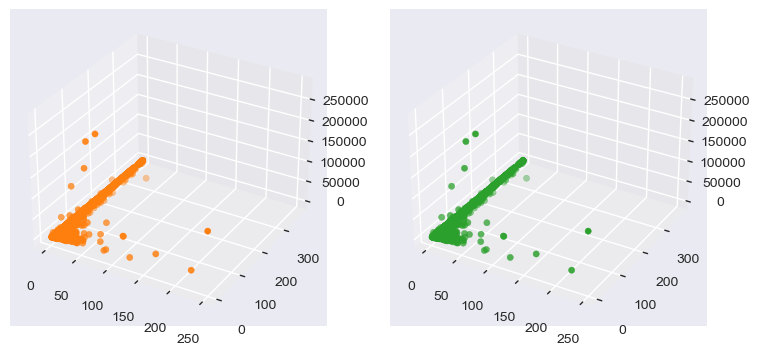

In [1202]:
# rgb colors corresponding to the color map


fig = plt.figure(figsize=(9,16))
cmap = plt.get_cmap('tab10')
rgb_cm = cmap.colors  # returns array-like color

n,cl=0,1
ax = fig.add_subplot(1, 2, n+1, projection='3d')
x = df_rfm_cs['Frequency'].values
y = df_rfm_cs['Recency'].values
z = df_rfm_cs['MonetaryValue'].values
c = df_rfm_cs['clabel'].values
ax.scatter(x,y,z, color=rgb_cm[cl])

n,cl=1,2
ax = fig.add_subplot(1, 2, n+1, projection='3d')
x = df_rfm_cs['Frequency'].values
y = df_rfm_cs['Recency'].values
z = df_rfm_cs['MonetaryValue'].values
c = df_rfm_cs['clabel'].values
ax.scatter(x,y,z, color=rgb_cm[cl])


plt.show()
    

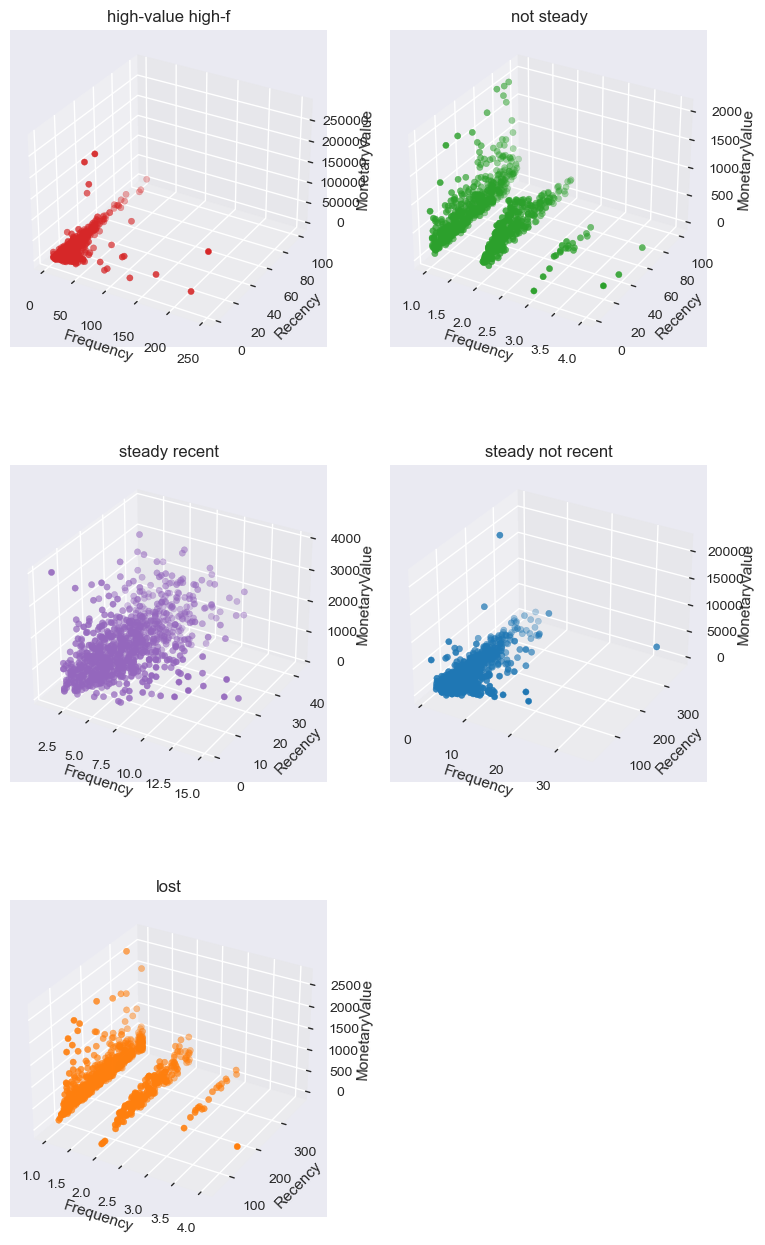

In [1205]:
#https://matplotlib.org/stable/gallery/mplot3d/subplot3d.html

# colormap to rgb 
#https://stackoverflow.com/questions/26108436/how-can-i-get-the-matplotlib-rgb-color-given-the-colormap-name-boundrynorm-an

# figure (width, height)
fig = plt.figure(figsize=(9,16))

# rgb colors corresponding to the color map
cmap = plt.get_cmap('tab10')
rgb_cm = cmap.colors  # returns array-like color

# set up the axes for the first plot

for n, cl in enumerate(cl_list):
    ax = fig.add_subplot(3, 2, n+1, projection='3d')
    scatter3d(df_rfm_cs[df_rfm_cs['clabel']==cl],"Frequency","Recency","MonetaryValue","clabel", color=rgb_cm[cl], ax=ax)
    title=cluster_interpretations[cl] 
    ax.set_title(title)

plt.show()

## Cluster Summaries

* **_high-value high-f_** - (1) These are the highest value customers with high order frequency, typically ordering 14 times per year. The concentration of members in this segment are recent and high frequency, however there are some members with high value (150K or greater) that are beginning to lapse (Recency of 60 days or higher).
* **_not steady_** - (0) - These customers typically have a low order frequency and are recent, Frequency cluster prototype Fc = 1.47, and Rc = 38 days. Thus many in this group have ordered only once. It follows that some of this group are new customers. Additionally, observing the corresponding cluster 0 scatter plot illustrates that some of these customers are beginning to lapse into possibly lost customers with Fc up to 100. There may be an opportunity to convert them to steady or high value customers, but some of them will also likely transition to lost customers. 
* **_steady recent_** - (4) These customers have steady order frequency. A frequency Fc prototype of 4.28 orders over a years time frame is typical and they have ordered in the past 9 day to 30 days.
* **_steady not recent_** -(2) These customers are similar to the previous case (Cluster 4), with a similar order frequency, but this group has not ordered within the last 50 days. The difference between the two (Cluster 4 and Cluster 2) could simply be the timeing of when this analysis was done. Cluster 2 customers (this group) could very well be ready to make an order soon.
* **_lost_** - (5) - This group seems to have ordered typically one time and has not ordered again in over 7 months. These appear to be lost customers. Understanding why they did not return is a worthy exercise and could lead to valuable insights leading to customer retention.


In [1206]:

# summaries dataframe
df_rfm_segment_summaries=df_rfm_cs.copy()

# add variables

df_rfm_segment_summaries["Ncustomers"] = df_rfm_segment_summaries["CustomerID"] # count total customers per segment
df_rfm_segment_summaries["TotalRevenue"] = df_rfm_segment_summaries["MonetaryValue"] # 
df_rfm_segment_summaries["Rmed"] = df_rfm_segment_summaries["Recency"] # 
df_rfm_segment_summaries["Rmin"] = df_rfm_segment_summaries["Recency"] # 
df_rfm_segment_summaries["Rmax"] = df_rfm_segment_summaries["Recency"] # 
df_rfm_segment_summaries["Fmed"] = df_rfm_segment_summaries["Frequency"] # 
df_rfm_segment_summaries["Fmin"] = df_rfm_segment_summaries["Frequency"] # 
df_rfm_segment_summaries["Fmax"] = df_rfm_segment_summaries["Frequency"] # 
df_rfm_segment_summaries["Mmed"] = df_rfm_segment_summaries["MonetaryValue"] # 
df_rfm_segment_summaries["Mmin"] = df_rfm_segment_summaries["MonetaryValue"] # 
df_rfm_segment_summaries["Mmax"] = df_rfm_segment_summaries["MonetaryValue"] # 

# aggregations

aggs={
    'clabel':'last',
    'Ncustomers':'count',
    'TotalRevenue':'sum',
    'Rmed':'median',
    'Rmin':'min',
    'Rmax':'max',
    'Fmed':'median',
    'Fmin':'min',
    'Fmax':'max',
    'Mmed':'median',
    'Mmin':'min',
    'Mmax':'max'
}
df_rfm_segment_summaries = df_rfm_segment_summaries.groupby('csegment').agg(aggs).reset_index()

# caluclations
df_rfm_segment_summaries['%Customers'] = df_rfm_segment_summaries['Ncustomers']/len(df_rfm_cs)
df_rfm_segment_summaries['%Revenue'] = df_rfm_segment_summaries['TotalRevenue']/df_rfm_segment_summaries['TotalRevenue'].sum()
df_rfm_segment_summaries['TotalRevenue'] = df_rfm_segment_summaries['TotalRevenue'].astype(int) # round this to 0 decimals ... the decimals are destracting

# add RFM centers
df_rfm_segment_summaries = df_rfm_segment_summaries.merge(df_centers_ibc, on="csegment")
df_rfm_segment_summaries = df_rfm_segment_summaries.merge(df_centers, on="csegment")
df_rfm_segment_summaries.rename({'R':'Rc','F':'Fc','M':'Mc'}, inplace=True,axis=1)   # add a 'c' to R, R, M columns to designate center
df_rfm_segment_summaries.rename({'r':'rc','f':'fc','m':'mc'}, inplace=True,axis=1)   # add a 'c' to R, R, M columns to designate center

df_rfm_segment_summaries

,csegment,clabel,Ncustomers,TotalRevenue,Rmed,Rmin,Rmax,Fmed,Fmin,Fmax,Mmed,Mmin,Mmax,%Customers,%Revenue,Rc,Fc,Mc,rc,fc,mc
0,high-value high-f,3,615,5372985,9.0,1,101,13.0,3,248,4241.63,1.296440e+03,279489.02,0.142361,0.646312,9.452898,13.309097,5304.997075,-1.085424,1.466813,1.617290
1,lost,1,953,286125,241.0,54,374,1.0,1,4,234.24,7.105427e-15,2661.24,0.220602,0.034418,225.815697,1.179336,226.912412,1.272292,-1.015898,-0.873313
2,not steady,2,881,311415,39.0,1,101,1.0,1,4,301.72,2.900000e+00,2062.06,0.203935,0.037460,34.596856,1.277046,288.784492,-0.256125,-0.899631,-0.706095
3,steady not recent,0,963,1220711,86.0,32,367,3.0,1,35,922.39,7.002000e+01,21535.90,0.222917,0.146839,95.868240,3.536115,1000.923109,0.520126,0.350848,0.214222
4,steady recent,4,908,1122056,15.0,1,43,5.0,1,15,1120.57,1.512300e+02,3861.00,0.210185,0.134971,12.824737,4.419797,1087.324078,-0.904866,0.573780,0.279155


# BI Data

Data needed for the dashboard

df_rfm with 
* 9 month rolling rfm values
* RFM current values 
* cluster label
* segment assignment
* customer ID
* country

RFM for months 9,10,11 based on 9 months historic data

In [1207]:
# start with df_sales_clean ... removed null CustomerID
# RFM month by mont based on previous 9 months
#  RFM_Nov2011 ... starting Mar 1 ... year = 2011, month = 11
#  RFM_Oct2011 ... starting Feb 1 ... year = 2011, month = 10
#  RFM_Sep2011 ... starting Jan 1 ... year = 2011, month = 9
# union (pandas concatenate)
# eliminate customers with net negative monetary value
# df_rfm_ym

# copy data and add month and year columns

# RFM aggs

aggs={
    'Recency': lambda x: (max_date_plus_1 - x.max()).days,
    'Frequency': 'nunique', # use nunique ... count will count duplicate when customer buys multiple items in one invoice
    'MonetaryValue': 'sum',
    'Country':'last'
    } 
months=[9,10,11]
year=2011
df_rfm_ym=pd.DataFrame()
for n,m in enumerate(months):
    # create tmp dataframe with 9 months of data going back including all of the current month
    df_tmp = df_sales_clean[df_sales_clean['InvoiceDate'] >= dt.datetime(year,m-9+1,1)]
    m_p1 = m + 1 if m < 12 else 1
    y = y + 1 if m == 12 else year
    df_tmp=df_tmp[df_tmp['InvoiceDate']< dt.datetime(y,m_p1,1)]
    df_tmp=df_tmp.sort_values("InvoiceDate", ascending=True)
    
    # RFM: create rfm variales and aggregate 
    df_tmp['Recency']=df_tmp['InvoiceDate']
    df_tmp['Frequency']=df_tmp['InvoiceNo']
    df_tmp['MonetaryValue']=df_tmp['SalesRevenue']
    max_date_plus_1 = df_tmp['InvoiceDate'].max()+ dt.timedelta(days=1)
    df_tmp = df_tmp.groupby(['CustomerID']).agg(aggs)
    df_tmp['year']=year
    df_tmp['month']=m
    df_rfm_ym = df_tmp if n == 0 else pd.concat([df_rfm_ym,df_tmp])

# remove df_tmp from memory    
del df_tmp

# eliminate customers with negative net negative 
df_rfm_ym = df_rfm_ym[df_rfm_ym["MonetaryValue"]>0]


Transform and Standardize month 9 .... prepare clustering unsupervised learning 
* df_rfm_9s
* Transform  
* standardize

In [1208]:
# copy month 9 data

df_rfm_9s = df_rfm_ym[df_rfm_ym['month']==9].copy()

# Box Cox Transforms
from scipy import stats
skew_cols=[ 'Recency','Frequency','MonetaryValue' ,   'r','f','m']
df_rfm_9s["r"] , r_lambda_9 = stats.boxcox(df_rfm_9s['Recency'])
df_rfm_9s["f"] , f_lambda_9 = stats.boxcox(df_rfm_9s['Frequency'])
df_rfm_9s["m"] , m_lambda_9 = stats.boxcox(df_rfm_9s['MonetaryValue'])

# fisher pearson skewness
skewness = df_rfm_9s[skew_cols].skew()
print("skewness = ")
display(pd.DataFrame(skewness).T) #skewness is a series ... transform to dataframe

# Standardize
from sklearn.preprocessing import StandardScaler
scaler9 = StandardScaler()
scaler9.fit(df_rfm_s[['r','f','m']])
df_rfm_9s[['r','f','m']]=scaler9.transform(df_rfm_9s[['r','f','m']])

display(df_rfm_9s.describe().T)


skewness = 


,Recency,Frequency,MonetaryValue,r,f,m
0,0.842061,8.910617,19.470149,-0.144096,0.148125,0.348315


,count,mean,std,min,25%,50%,75%,max
Recency,3426.0,80.194980,74.902085,1.000000e+00,1.600000e+01,54.000000,131.000000,270.000000
Frequency,3426.0,4.129013,6.873433,1.000000e+00,1.000000e+00,2.000000,4.000000,153.000000
MonetaryValue,3426.0,1549.736224,6338.335226,3.552714e-15,2.699700e+02,582.135000,1379.435000,193797.760000
year,3426.0,2011.000000,0.000000,2.011000e+03,2.011000e+03,2011.000000,2011.000000,2011.000000
month,3426.0,9.000000,0.000000,9.000000e+00,9.000000e+00,9.000000,9.000000,9.000000
r,3426.0,7.008469,3.576597,9.210739e-17,4.118286e+00,7.149795,10.073533,13.033374
f,3426.0,0.661307,0.562347,6.743577e-17,6.743577e-17,0.601021,1.049691,2.086885
m,3426.0,8.703824,2.211606,-1.084318e+01,7.215994e+00,8.510445,10.070947,21.678187


heatmap first 9 months RFM segments

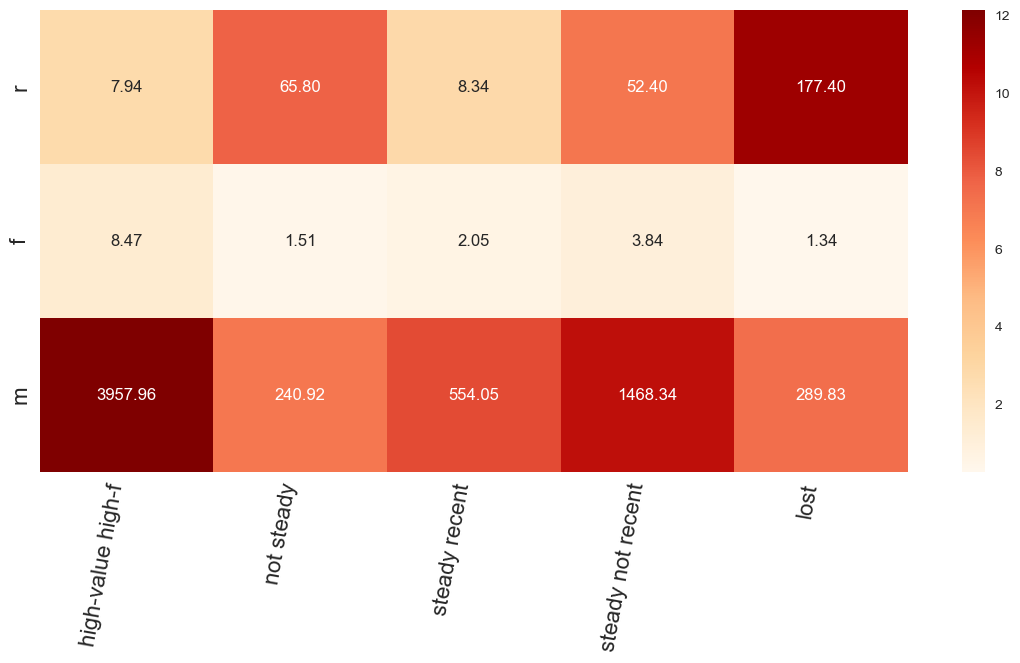

,high-value high-f,not steady,steady recent,steady not recent,lost
R,7.936186,65.796303,8.337646,52.403827,177.395952
F,8.474534,1.505857,2.049088,3.841384,1.338542
M,3957.956180,240.915034,554.051801,1468.342261,289.828290


In [1214]:

k = 5
cluster_cols9=['r','f','m']
kmeans9 = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans9.fit(df_rfm_9s[cluster_cols9])

df_centers_9 = pd.DataFrame(data=kmeans9.cluster_centers_,columns=cluster_cols9)
df_centers_9_T = df_centers_9.T # index are cluster cols, ... cols are cluster_num (cluster_label)

# get centers in the original non-transformed variable space
# inverse standard scaler
df_centers_ibc9=pd.DataFrame(scaler.inverse_transform(df_centers_9[['r','f','m']]), columns=['R','F','M'] )
  
# inverse standard scaler
df_centers_ibc9=pd.DataFrame(scaler9.inverse_transform(df_centers_9[['r','f','m']]), columns=['R','F','M'] )
   
# inverse boxcox
# https://stackoverflow.com/questions/26391454/reverse-box-cox-transformation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html   
   
from scipy.special import inv_boxcox
df_centers_ibc9["R"] = inv_boxcox(df_centers_ibc9['R'],r_lambda_9)
df_centers_ibc9["F"] = inv_boxcox(df_centers_ibc9['F'],f_lambda_9)
df_centers_ibc9["M"] = inv_boxcox(df_centers_ibc9['M'],m_lambda_9)
df_centers_ibc9_T = df_centers_ibc9.T

# reorder columns for better visualizaion/interpretation
cl_list9=[4,0,2,3,1]  # k =5
df_centers_9_T = df_centers_9_T[cl_list9]
df_centers_ibc9_T = df_centers_ibc9_T[cl_list9]

# iteratively name the clusters with human interpretation
# keep the origin numeric label in parenthesis for reference
# comment when trying new k
# k = 5
cluster_interpretations9={ 4:'high-value high-f', 0:'not steady', 2:'steady recent' , 3:'steady not recent',  1:'lost'  } 

df_centers_9_T.rename(cluster_interpretations9,axis=1,inplace=True)
df_centers_ibc9_T.rename(cluster_interpretations9,axis=1,inplace=True)

# put iterprentations bac into non transposed dataframe
df_centers_ibc9 = df_centers_ibc9_T.T.reset_index().rename({"index":"csegment"},axis=1)
df_centers_9 = df_centers_9_T.T.reset_index().rename({"index":"csegment"},axis=1)

# heatmap on transformed variables for better visualization
# annotate with the non-transformed values for better interpretation
annot9= df_centers_ibc9_T.values  #  # annotation form = [[],[]] ..] ... n-col (cluster cols) x k-values (k-clusters) ... each sub-array has k values               
clusterheatmap(df_centers_9_T, annot=annot9, fmt='.2f',figsize=(14,6))


# print centers in non-transformed (inverse boxcox) for better understanding/interpretation
display(df_centers_ibc9_T)

euclidean distance to label algorithm

In [1215]:
# Find label with Min Euclidean Distance to rfm 

# centers and labels DataFrame
df_centers_labels = df_centers_9.copy()
df_centers_labels['clabel'] = cl_list9
display(df_centers_labels)

# dictionary ... clabels to centers
clabels_centers_dict={}
def make_clabels_centers_dict(row):
    clabels_centers_dict[row['clabel']] = np.array([row['r'],row['f'],row['m']])
    return None
_ = df_centers_labels.apply(lambda row: make_clabels_centers_dict(row),axis=1)

#print(f'clabels_centers_dict = {clabels_centers_dict}')

# min rfm euclidian distance to label algorithm
def min_edist_to_label(row):
    rfm_ar = np.array([row['r'],row['f'],row['m']])
    #print(f'rfm_ar = {rfm_ar}')
    for n,k in enumerate(clabels_centers_dict.keys()):
        edist = np.linalg.norm(rfm_ar - clabels_centers_dict[k])
        #print(f'  k,edist, center = {k}, {edist} ,{clabels_centers_dict[k]}')
        if n==0:
            kmin = k
            edist_min = edist
            #print(f'    n = 0, k = {k}, edist = {edist}, edist_min = {edist_min}, kmin = {kmin}')
        else:
            if edist < edist_min: 
                edist_min = edist
                kmin = k
            #print(f'     k = {k}, edist = {edist}, edist_min = {edist_min} kmin = {kmin} ') 
    #print(f'  kmin = {kmin}')   
    label = kmin
    return label

# test the algorithm
df_test = df_rfm_bi.loc[(2011,11)].head(5).copy()
df_test['clabel'] = df_test.apply(lambda row: min_edist_to_label(row),axis=1)
display(df_test)

,csegment,r,f,m,clabel
0,high-value high-f,2.771845,1.408313,12.143838,4
1,not steady,7.742684,0.375973,7.031440,0
2,steady recent,2.858534,0.619030,8.424516,2
3,steady not recent,7.062481,1.026949,10.188545,3
4,lost,11.244719,0.274365,7.331965,1


CustomerID  Recency  Frequency  MonetaryValue  Country         r  \
year month                                                                     
2011 11        12347.0       31          4        2898.00  Iceland  0.134269   
     11        12348.0       67          2         677.00  Finland  1.020458   
     11        12349.0       10          1        1757.55    Italy -0.875289   
     11        12352.0       28         10        1248.91   Norway  0.030366   
     11        12353.0      196          1          89.00  Bahrain  2.604526   

                   f         m  clabel           csegment  
year month                                                 
2011 11     0.371946  1.076716       2  high-value high-f  
     11    -0.328425 -0.091087       2  steady not recent  
     11    -1.266615  0.658281       2      steady recent  
     11     1.033083  0.382728       2  high-value high-f  
     11    -1.266615 -1.492045       0               lost

df_rfm_bi  
* transformed r,f,m month 9 from above
* transform and standardize months 10,11 ... based on month 9 learned transforms
* Month 9 cluster Labels ... from kmeans
* Month 10, 11 cluster labels ...  min Euclidean to cluster centers
* Segment names/interpretations

In [1216]:
# df_rfm_bi ... set index to year month for easy indexing
df_rfm_bi = df_rfm_ym.copy().reset_index()
df_rfm_bi = df_rfm_bi.set_index(['year','month']) # set index for easy indexing of (year,month)
#display(df_rfm_bi)

# Transform and Standardize r, f, m into df_rfm_bi
  # month 9 is already transformed and standardized
df_rfm_bi[['r','f','m']]=np.NaN,np.NaN,np.NaN
df_rfm_bi.loc[(2011,9),['r','f','m']]=df_rfm_9s[['r','f','m']].values
  # transform months 10, 11 ... use the lambda learned from month 9

df_rfm_bi.loc[(2011,10),'r'] =  stats.boxcox( df_rfm_bi.loc[(2011,10),'Recency'], lmbda=r_lambda_9 )
df_rfm_bi.loc[(2011,11),'r'] =  stats.boxcox(df_rfm_bi.loc[(2011,11),'Recency'],lmbda=r_lambda_9 )
df_rfm_bi.loc[(2011,10),'f'] =  stats.boxcox( df_rfm_bi.loc[(2011,10),'Frequency'], lmbda=f_lambda_9 )
df_rfm_bi.loc[(2011,11),'f'] =  stats.boxcox(df_rfm_bi.loc[(2011,11),'Frequency'],lmbda=f_lambda_9 )
df_rfm_bi.loc[(2011,10),'m'] =  stats.boxcox( df_rfm_bi.loc[(2011,10),'MonetaryValue'], lmbda=m_lambda_9 )
df_rfm_bi.loc[(2011,11),'m'] =  stats.boxcox(df_rfm_bi.loc[(2011,11),'MonetaryValue'],lmbda=m_lambda_9 )

# Standardize 10, 11 ... use scaler learned from month 9
df_rfm_bi.loc[(2011,10),['r','f','m']]=scaler9.transform(df_rfm_bi.loc[(2011,10)][['r','f','m']])
df_rfm_bi.loc[(2011,11),['r','f','m']]=scaler9.transform(df_rfm_bi.loc[(2011,11)][['r','f','m']])

# month 9 ... clabels
#df_rfm_bi['clabels']=np.NaN
#df_rfm_bi['csegment']=np.NaN
df_rfm_bi.loc[(2011,9),'clabel'] = kmeans9.labels_  # labels into month 9

# month 10, 11 clabels
df_rfm_bi.loc[(2011,10) ,'clabel'] = df_rfm_bi.loc[(2011,10)].apply(lambda row: min_edist_to_label(row),axis=1)
df_rfm_bi.loc[(2011,11) ,'clabel'] = df_rfm_bi.loc[(2011,11)].apply(lambda row: min_edist_to_label(row),axis=1)
df_rfm_bi['clabel'] = df_rfm_bi['clabel'].astype(int)  # needs to be int for dictionary key lookup

# add segment names from clabels
df_rfm_bi['csegment'] = df_rfm_bi['clabel'].apply(lambda x: cluster_interpretations9[x])

df_rfm_bi

CustomerID  Recency  Frequency  MonetaryValue         Country  \
year month                                                                  
2011 9         12347.0       60          4        2079.07         Iceland   
     9         12348.0        6          3         904.44         Finland   
     9         12350.0      241          1         334.40          Norway   
     9         12352.0        3         10        1233.68          Norway   
     9         12353.0      135          1          89.00         Bahrain   
...                ...      ...        ...            ...             ...   
     11        18280.0      269          1         180.60  United Kingdom   
     11        18281.0      172          1          80.82  United Kingdom   
     11        18282.0      114          2          98.76  United Kingdom   
     11        18283.0        1         12        1568.98  United Kingdom   
     11        18287.0       34          3        1837.28  United Kingdom   

                       r             f          m  clabel           csegment  
year month                                                                    
2011 9      7.462036e+00  1.049691e+00  10.855182       3  steady not recent  
     9      2.301696e+00  8.792395e-01   9.292767       2      steady recent  
     9      1.252943e+01  6.743577e-17   7.567884       1               lost  
     9      1.278038e+00  1.473227e+00   9.862282       2      steady recent  
     9      1.018550e+01  6.743577e-17   5.493147       1               lost  
...                  ...           ...        ...     ...                ...  
     11     1.301667e+01  6.743577e-17   6.572492       1               lost  
     11     1.112098e+01  6.743577e-17   5.351179       1               lost  
     11     9.567681e+00  6.010210e-01   5.647716       0         not steady  
     11     9.210739e-17  1.539676e+00  10.314059       4  high-value high-f  
     11     5.878770e+00  8.792395e-01  10.615881       3  steady not recent  

[11053 rows x 10 columns]

Save BI data

In [1220]:
# RFM CustomerIDs and Clusters
filename = 'rfm_bi9.csv'
cols = ['CustomerID','Recency','Frequency','MonetaryValue','Country' , 'clabel','csegment']
display(df_rfm_bi[cols].head(5))
df_rfm_bi[cols].to_csv(f'{datapath}/{filename}')
print(f'{datapath}/{filename}')

# DF Centers inverst standardizationa and inverse boxcox
display(df_centers_ibc9)
filename = 'rfm_centers9_invsbc.csv'
df_centers_ibc9.to_csv(f'{datapath}/{filename}',index=False)
print(f'{datapath}/{filename}')

# DF Centers inverst standardizationa and inverse boxcox
display(df_centers_9)
filename = 'rfm_centers9.csv'
df_centers_9.to_csv(f'{datapath}/{filename}', index=False)
print(f'{datapath}/{filename}')


CustomerID  Recency  Frequency  MonetaryValue  Country  clabel  \
year month                                                                   
2011 9         12347.0       60          4        2079.07  Iceland       3   
     9         12348.0        6          3         904.44  Finland       2   
     9         12350.0      241          1         334.40   Norway       1   
     9         12352.0        3         10        1233.68   Norway       2   
     9         12353.0      135          1          89.00  Bahrain       1   

                     csegment  
year month                     
2011 9      steady not recent  
     9          steady recent  
     9                   lost  
     9          steady recent  
     9                   lost

./data_onlinesales/rfm_bi9.csv


,csegment,R,F,M
0,high-value high-f,7.936186,8.474534,3957.956180
1,not steady,65.796303,1.505857,240.915034
2,steady recent,8.337646,2.049088,554.051801
3,steady not recent,52.403827,3.841384,1468.342261
4,lost,177.395952,1.338542,289.828290


./data_onlinesales/rfm_centers9_invsbc.csv


,csegment,r,f,m
0,high-value high-f,2.771845,1.408313,12.143838
1,not steady,7.742684,0.375973,7.031440
2,steady recent,2.858534,0.619030,8.424516
3,steady not recent,7.062481,1.026949,10.188545
4,lost,11.244719,0.274365,7.331965


./data_onlinesales/rfm_centers9.csv


# BI Dashboard

https://lookerstudio.google.com/s/tUVQIq0a2QE

# References

* Chen, D., Sain, S. & Guo, K. Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. J Database Mark Cust Strategy Manag 19, 197–208 (2012). https://doi.org/10.1057/dbm.2012.17

* Customer Segmentation in Python, Segmentation Using K-Means clustering algorithm, by Irfan Alghani Khalid, June 1, 2020, https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945

* Transforming Skewed Data for Machine Learning, by Nathanial Jermain, June 24, 2019, https://opendatascience.com/transforming-skewed-data-for-machine-learning/